<a href="https://colab.research.google.com/github/iakpathan/Voice2Vision/blob/main/Voice2Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pydub faster-whisper diffusers transformers accelerate groq
#installing dependencies

In [ ]:
from IPython.display import Javascript
from google.colab import output
import base64

# 🔧 Async wrapper for recording
RECORD_AUDIO = """
async function recordAudio() {
  const sleep = time => new Promise(resolve => setTimeout(resolve, time));
  const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
  const recorder = new MediaRecorder(stream);
  const data = [];

  recorder.ondataavailable = event => data.push(event.data);
  recorder.start();

  await sleep(5000);  // 🎤 Record for 5 seconds
  recorder.stop();

  await new Promise(resolve => recorder.onstop = resolve);
  const blob = new Blob(data, { type: 'audio/webm' });
  const arrayBuffer = await blob.arrayBuffer();
  const base64 = btoa(String.fromCharCode(...new Uint8Array(arrayBuffer)));

  return base64;
}
recordAudio();
"""

# 👂 Run async JS and return result
print("🎤 Recording for 5 seconds...")
audio_b64 = output.eval_js(RECORD_AUDIO)

# 💾 Save file
with open("input.webm", "wb") as f:
    f.write(base64.b64decode(audio_b64))
print("✅ Audio saved as input.webm")


🎤 Recording for 5 seconds...
✅ Audio saved as input.webm


In [ ]:
from pydub import AudioSegment
from faster_whisper import WhisperModel

# Convert to wav
audio = AudioSegment.from_file("input.webm")
audio.export("input.wav", format="wav")

# Transcribe with Whisper
model = WhisperModel("base")
segments, _ = model.transcribe("input.wav", beam_size=5)
transcription = " ".join([seg.text for seg in segments])
print("📝 Transcribed text:", transcription)


📝 Transcribed text:  Generate an image of a village


In [ ]:
import ipywidgets as widgets
from IPython.display import display

styles = ["Realistic", "Anime", "Cartoon", "Cyberpunk", "Van Gogh", "Pixel Art"]
style_dropdown = widgets.Dropdown(options=styles, description="🎨 Style:")
display(style_dropdown)


Dropdown(description='🎨 Style:', options=('Realistic', 'Anime', 'Cartoon', 'Cyberpunk', 'Van Gogh', 'Pixel Art…

In [ ]:
from groq import Groq
from transformers import AutoTokenizer  # Install: pip install transformers

# Setup
groq_api_key = "api-key"
client = Groq(api_key=groq_api_key)

# Sample Inputs

tokenizer = AutoTokenizer.from_pretrained("gpt2")


# 1. Generate visual enhancement (30 tokens)
enhancement_response = client.chat.completions.create(
    model="llama3-70b-8192",
    messages=[
        {"role": "system", "content": "Create a vivid 30-token visual enhancement for an AI art prompt. Use rich adjectives, lighting effects, and artistic terms."},
        {"role": "user", "content": f"Enhance the beginning of: {transcription[:100]}"}
    ],
    max_tokens=30
)

enhancement = enhancement_response.choices[0].message.content.strip()

# 2. Build full prompt and trim to 77 tokens
full_prompt = f"{enhancement}, {transcription}, in {style_dropdown.value} style"
tokens = tokenizer.encode(full_prompt)

# Trim if needed
if len(tokens) > 77:
    tokens = tokens[:77]
    final_prompt = tokenizer.decode(tokens, skip_special_tokens=True)
else:
    final_prompt = full_prompt

# Output
print("✨ Enhanced Prompt (<=77 tokens):", final_prompt)
print("Token count:", len(tokenizer.encode(final_prompt)))


✨ Enhanced Prompt (<=77 tokens): Here is a 30-token visual enhancement for the AI art prompt:

"Illuminate a serene, moonlit village, nestled within a lush, emerald,  Generate an image of a village, in Anime style
Token count: 49


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

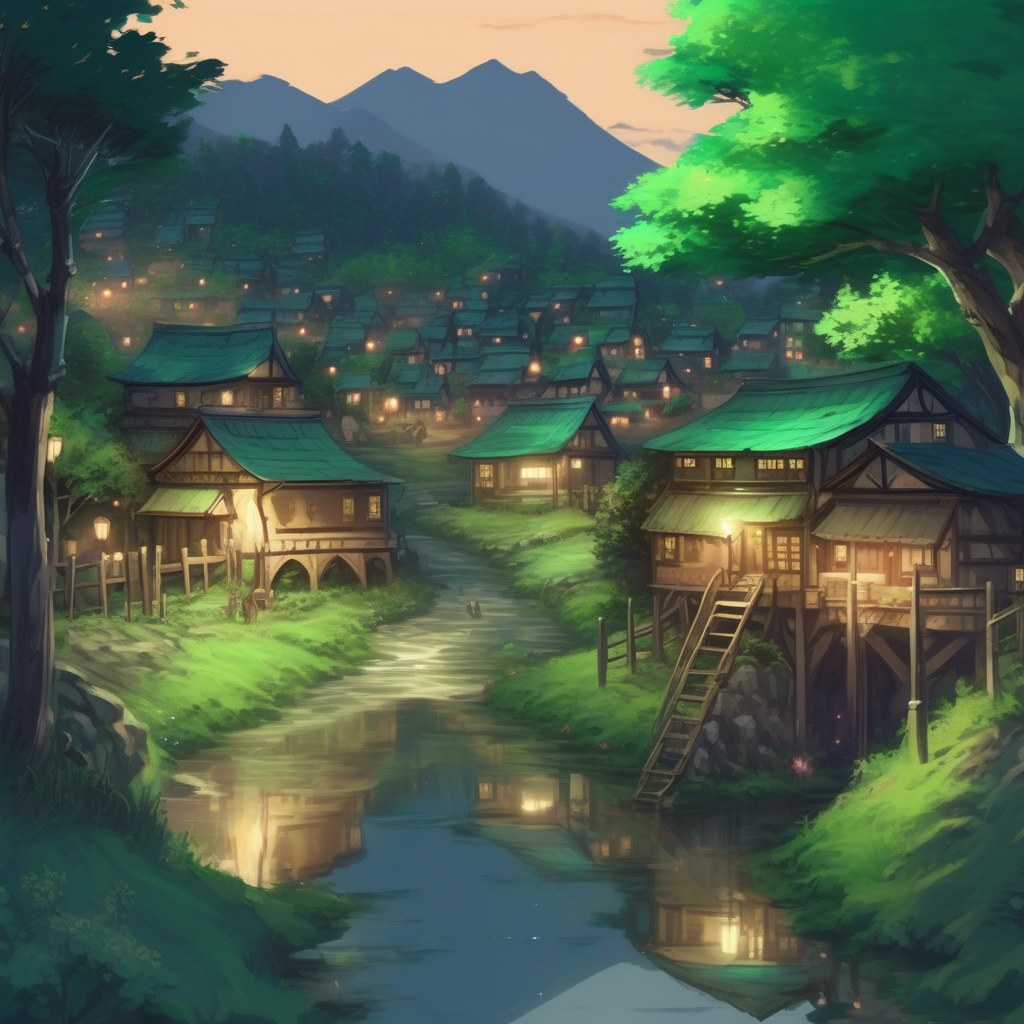

In [ ]:
from diffusers import StableDiffusionXLPipeline
from PIL import Image
import torch

# Auto detect device
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

# Load SDXL 1.0 model
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=dtype,
    variant="fp16" if dtype == torch.float16 else None,
    use_safetensors=True
).to(device)

# Run the pipeline
image = pipe(prompt=final_prompt, guidance_scale=12.5, num_inference_steps=50).images[0]

# Save and show
image.save("output.png", format="PNG")
image.show()

# Display in Colab
from IPython.display import Image as IPImage, display
display(IPImage(filename="output.png"))


In [ ]:
from google.colab import files
files.download("output.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>